In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sim_functions import *

#from tqdm import tqdm

from scipy.optimize import curve_fit

from tqdm.auto import tqdm
from joblib import Parallel, delayed

Using cupy


In [2]:
nx = 800
ny = 50 # 5mm
steps = 20000
output_stride = 1000
profile_interval = 1000

In [6]:
molecular_weights = np.array([1,80, 17, 8]) # H2, TMIn, PH3, CH4
n_species = len(molecular_weights)
multiplier = 19.0
'''
Bss = multiplier * 1/np.sqrt(1/molecular_weights[0] + 1/molecular_weights[1])
D_lbm = 1/Bss
print('Predict diffusion constant = ', D_lbm)
'''
phi_1 = 0.487
phis = phi_1 * molecular_weights[0]/molecular_weights
print(phis)

predict_lambda = (phi_1 /3) * multiplier * 1/np.sqrt(1/molecular_weights[0] + 1/molecular_weights[0])
relaxation = predict_lambda/(1+predict_lambda/2)
viscosity_kinematic = 1/3 * (1/relaxation - 0.5)
print('viscosity_kinematic = ',viscosity_kinematic)

[0.487      0.0060875  0.02864706 0.060875  ]
viscosity_kinematic =  0.15283838348352918


In [7]:
D_s = 1/(multiplier * 1/np.sqrt(1/molecular_weights[0] + 1/molecular_weights))
print('D_s = ',D_s)

D_s =  [0.07443229 0.0529595  0.05415745 0.05582422]


In [8]:
vx = 0.003
v_top = xp.array([vx, 0])
c_top = xp.array([0.979, 0.000047, 0.0204, 1e-4])
print("ratio = ", c_top[2]/c_top[1])
print(np.sum(c_top))
absorption_ratio = xp.array([0,1,1,-3])
print(3*c_top)

ratio =  434.04255319148945
0.999547
[2.937e+00 1.410e-04 6.120e-02 3.000e-04]


nx_ratio =  1000.0
40.0


(250.0, 550.0)

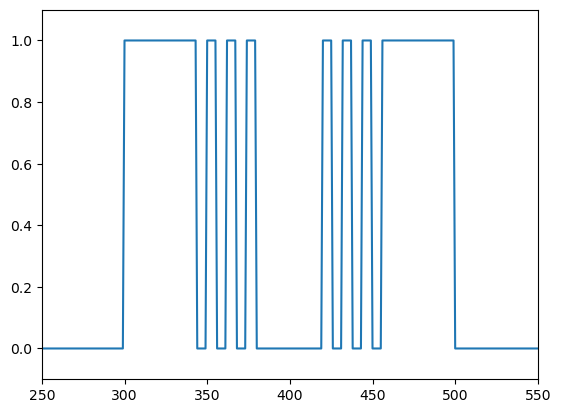

In [9]:
L_grid = 0.5

nx_ratio = 500/0.5
print('nx_ratio = ',nx_ratio)

L_gap = 20 //L_grid
L_mask1 = 3//L_grid
L_mask2 = 3//L_grid
L_mask_side = 40//L_grid-3*(L_mask1+L_mask2)

print(L_gap)

non_absorb_mask = xp.zeros(nx)
non_absorb_mask[nx//2+L_gap//2 : nx//2+L_gap//2+L_mask1] = True
non_absorb_mask[nx//2+L_gap//2+L_mask1+L_mask2 : nx//2+L_gap//2+2*L_mask1+L_mask2] = True
non_absorb_mask[nx//2+L_gap//2+2*L_mask1+2*L_mask2 : nx//2+L_gap//2+3*L_mask1+2*L_mask2] = True
non_absorb_mask[nx//2+L_gap//2+3*L_mask1+3*L_mask2 : nx//2+L_gap//2+3*L_mask1+3*L_mask2+L_mask_side] = True

non_absorb_mask[0: nx//2] = non_absorb_mask[nx//2:][::-1]

plt.plot(to_numpy(non_absorb_mask))
plt.ylim([-0.1, 1.1])
plt.xlim([250,550])

In [7]:
lbm_config = lbm_parameters(
    nx=nx,
    ny=ny,
    steps=steps,
    output_interval=output_stride,
    molecular_weights=xp.array(molecular_weights),
    multiplier=multiplier,
    phis=xp.array(phis),
    D_s=xp.array(D_s),
    v_top = v_top, # vx, vy
    c_top = c_top, # partial pressure
    non_absorb_mask=xp.array(non_absorb_mask),
    absorption_ratio = xp.array(absorption_ratio),
)

In [8]:
vx_ini = vx
total_pressure = 1
partial_pressure = c_top

y_coord = xp.arange(ny)
velocity_profile = vx_ini * y_coord/ny

ux_s = xp.ones((n_species, nx, ny), dtype=xp.float32) * velocity_profile[None, None, :]
uy_s = xp.zeros((n_species, nx, ny), dtype=xp.float32)

rho_s = xp.zeros((n_species, nx,ny))
for s in range(n_species):
    rho_s[s,:,:] = 3* partial_pressure[s] * xp.ones((nx,ny))

f = xp.zeros((n_species, 9, nx, ny), dtype=DTYPE)
feq = equilibrium(f, rho_s, lbm_config, ux_s, uy_s)
f = feq

f_cross_ini = feq[:, :, nx//2, :]

f_end = None

In [9]:
def main(f, lbm_config):
    clip_history = []
    f_cross = []
    for step in tqdm(range(lbm_config.steps + 1)):
        f, clipped = bgk_step(f, lbm_config, top_moving_left_intake_bottom_absorb_4_species)
        clip_history.append(clipped)

        if step % profile_interval == 0:
            f_cross.append(f[1, :, nx//2, :])

        if step == steps:
            break

    return np.array(clip_history), to_numpy(xp.array(f_cross)), to_numpy(f)

In [10]:
def single_run(absorption_coefficient):
    comp2_bc = xp.array([absorption_coefficient, 1, 0])
    lbm_config = lbm_parameters(
        nx=nx,
        ny=ny,
        steps=steps,
        output_interval=output_stride,
        molecular_weights=xp.array(molecular_weights),
        multiplier=multiplier,
        phis=xp.array(phis),
        D_s=xp.array(D_s),
        v_top = v_top, # vx, vy
        c_top = c_top, # partial pressure
        non_absorb_mask=xp.array(non_absorb_mask),
        comp2_bc =comp2_bc,
        absorption_ratio = xp.array(absorption_ratio),
    )
    clip_history, f_cross, f_end = main(f, lbm_config)
    return clip_history, f_cross, f_end

def sweep_absorption(abs_coefs):
    results = Parallel(n_jobs=2, backend="loky")(
        delayed(single_run)(absorption_coefficient)
        for absorption_coefficient in tqdm(abs_coefs, total = len(abs_coefs))
    )
    clip_history_list, f_cross_list, f_end_list = zip(*results)
    return to_numpy(clip_history_list), to_numpy(f_cross_list), to_numpy(f_end_list)

In [11]:
abs_coefs = [5, 10, 50 ,100, 150, 200, 400, 1000]
clip_history_list, f_cross_list, f_end_list = sweep_absorption(abs_coefs)
np.save("f_sample_result_list", f_end_list)

  0%|          | 0/8 [00:00<?, ?it/s]

(8, 4, 9, 800, 400)
(8, 4, 800, 400)


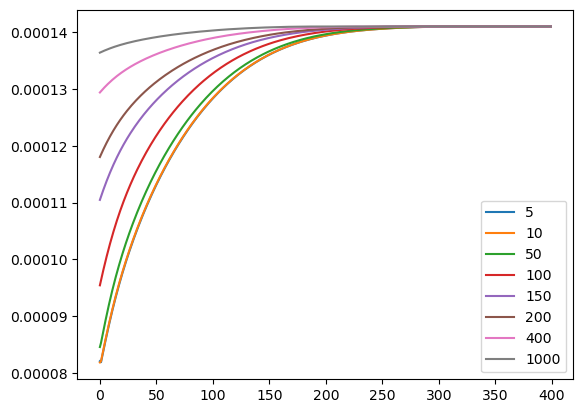

In [12]:
f_end_list = np.array(f_end_list)
print(f_end_list.shape)
rho_s_list = np.sum(f_end_list, axis = 2)
print(rho_s_list.shape)

species_index = 1
flux1_list = []
b1_measured_list = []
for i in range(f_end_list.shape[0]):
    plt.plot(rho_s_list[i, species_index, nx//2, :], label = abs_coefs[i])
    slope = (rho_s_list[i, species_index, nx//2, 3]-rho_s_list[i, species_index, nx//2, 0])/3
    flux1_list.append(slope*D_s[species_index])
    b1_measured_list.append(rho_s_list[i, species_index, nx//2, 0]/slope)

plt.legend()

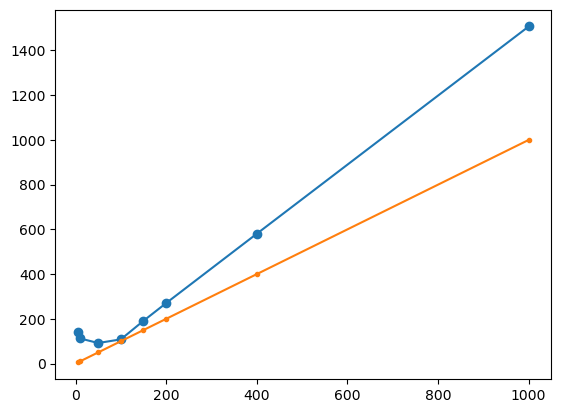

In [13]:
plt.plot(abs_coefs, b1_measured_list, marker='o')
plt.plot(abs_coefs, abs_coefs, marker='.')

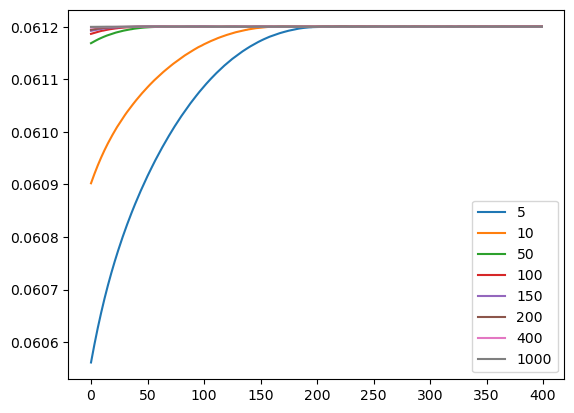

In [14]:
species_index = 2
flux2_list = []
b1_measured_list = []
for i in range(f_end_list.shape[0]):
    plt.plot(rho_s_list[i, species_index, nx//2, :], label = abs_coefs[i])
    slope = (rho_s_list[i, species_index, nx//2, 3]-rho_s_list[i, species_index, nx//2, 0])/3
    flux2_list.append(slope*D_s[species_index])
plt.legend()

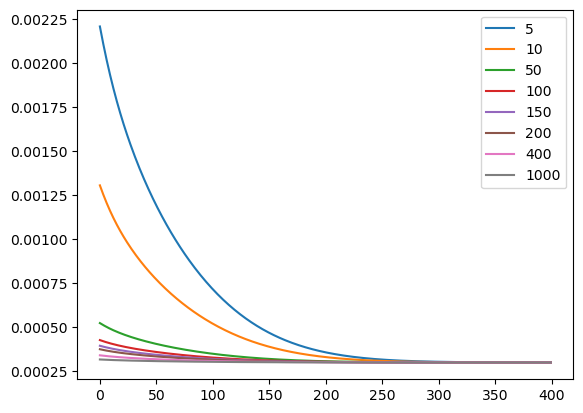

In [15]:
species_index = 3
flux3_list = []
b1_measured_list = []
for i in range(f_end_list.shape[0]):
    plt.plot(rho_s_list[i, species_index, nx//2, :], label = abs_coefs[i])
    slope = (rho_s_list[i, species_index, nx//2, 3]-rho_s_list[i, species_index, nx//2, 0])/3
    flux3_list.append(slope*D_s[species_index])
plt.legend()

(-5.0, 2.0)

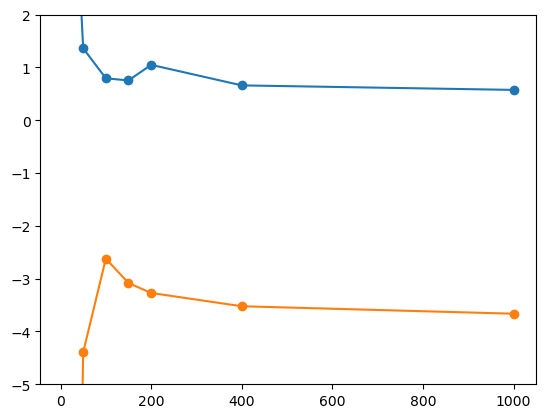

In [16]:
ratio1 = np.array(flux2_list)/np.array(flux1_list)
ratio2 = np.array(flux3_list)/np.array(flux1_list)
plt.plot(abs_coefs, ratio1, marker='o')
plt.plot(abs_coefs, ratio2, marker='o')
plt.ylim(-5, 2)

(8, 21, 9, 400)
(20,)
(20,)
(20,)
(20,)
(20,)
(20,)
(20,)
(20,)


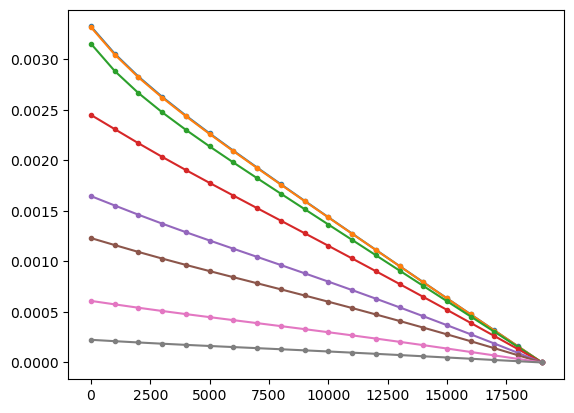

In [17]:
f_cross_list = np.array(f_cross_list)
print(f_cross_list.shape)
for i in range(f_cross_list.shape[0]):
    err = []
    for j in range(f_cross_list.shape[1]-1):
        error = np.sum(np.abs(f_cross_list[i, -j-1, :, :] - f_cross_list[i, -1, :, :]))
        err.append(error)
    err = np.array(err)
    print(err.shape)
    plt.plot(np.arange(len(err))*profile_interval, err[::-1], marker = ".")